In [5]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

2023-07-12 22:22:41,805 - /Users/kakao/.pyenv/versions/3.9.15/envs/causality-study/lib/python3.9/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [6]:
SEED = 18
np.random.seed(SEED)

In [7]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

## Synthetic data

In [8]:
# Generate a scale-free adjacency matrix
adj_matrix = DAG.scale_free(
    n_nodes=10,
    n_edges=17,
    seed=SEED
)

adj_matrix

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]])

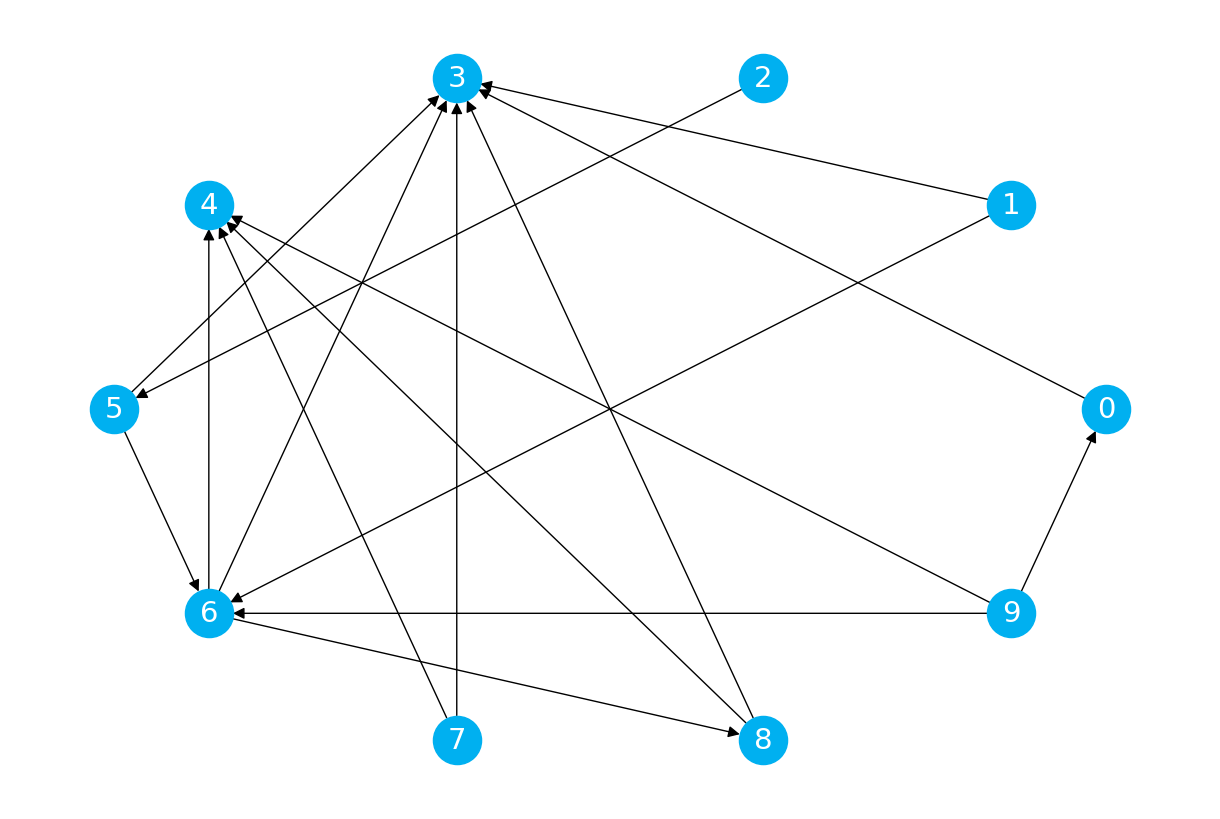

In [9]:
# Visualize the adjacency matrix
g = nx.DiGraph(adj_matrix)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

In [10]:
dataset = IIDSimulation(
    W=adj_matrix, 
    n=10000, 
    method='linear', 
    sem_type='gauss'
)

2023-07-12 22:22:42,021 - /Users/kakao/.pyenv/versions/3.9.15/envs/causality-study/lib/python3.9/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


In [11]:
dataset.X.shape

(10000, 10)

## causal discovery

In [12]:
pc = PC()

In [13]:
pc.learn(dataset.X)

In [14]:
pred_dag = pc.causal_matrix
pred_dag

Tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0]])

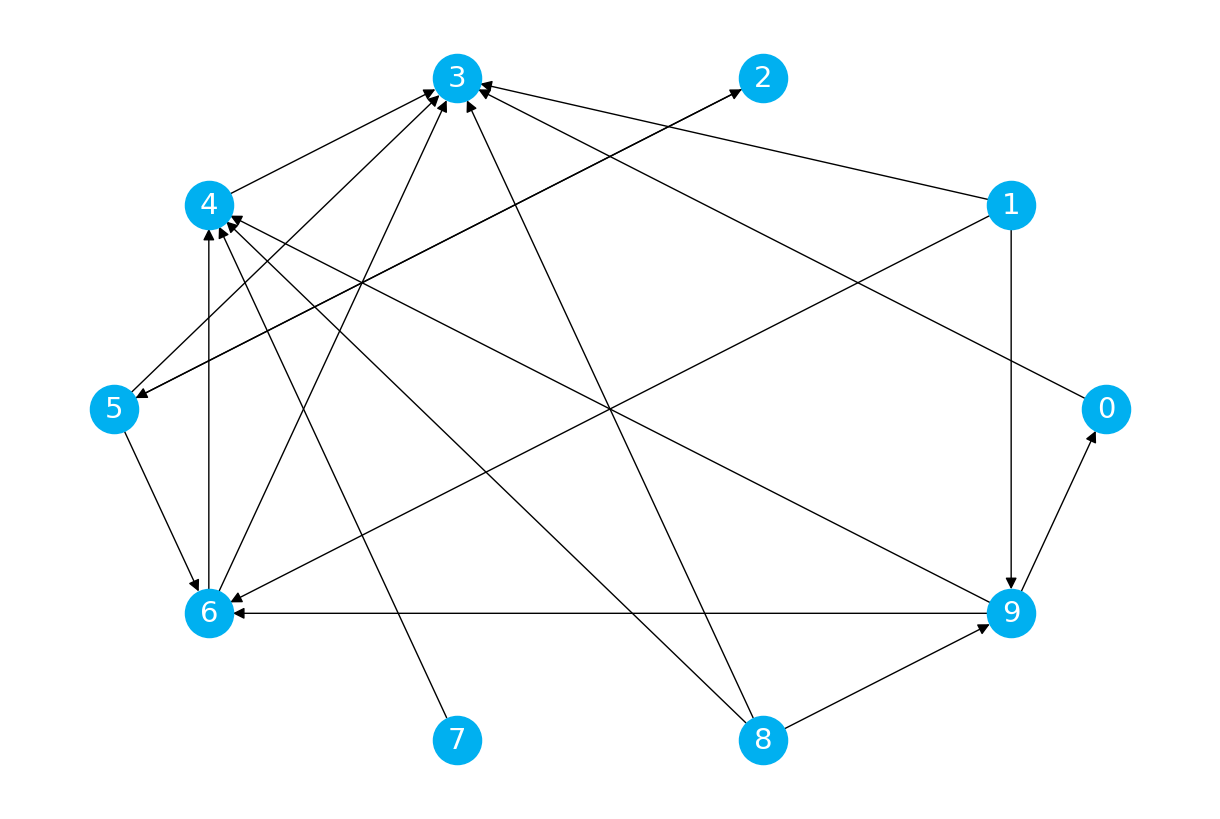

In [15]:
g_pred = nx.DiGraph(pred_dag)

plt.figure(figsize=(12, 8))
nx.draw(
    G=g_pred,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(g)
)

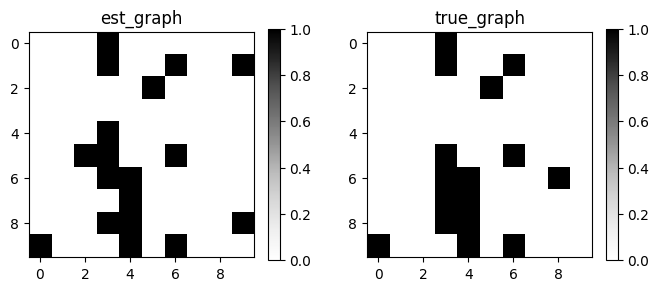

In [16]:
GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [17]:
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)


In [18]:
metrics.metrics

{'fdr': 0.1765,
 'tpr': 0.875,
 'fpr': 0.1034,
 'shd': 5,
 'nnz': 17,
 'precision': 0.7778,
 'recall': 0.875,
 'F1': 0.8235,
 'gscore': 0.625}

## Constraint-based causal discovery

### PC algorithm
- fully-connected graph에서 데이터의 independency를 이용하여 graph edge들을 iteratively 지워나간다.

In [19]:
# Build a DAG adj matrix
pc_dag = np.array([
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])

# Generate data from this DAG
N = 1000

p = np.random.randn(N)
q = np.random.randn(N)

r = p + q + .1 * np.random.randn(N)
s = .7 * r + .1 * np.random.randn(N)

pc_dataset = np.vstack([p, q, r, s]).T

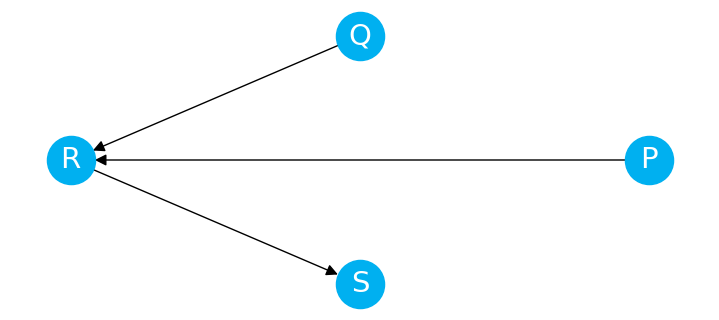

In [20]:
true_graph = nx.DiGraph(pc_dag)

MAPPING = {k: v for k, v in zip(range(4), ['P', 'Q', 'R', 'S'])}
true_graph = nx.relabel_nodes(true_graph, MAPPING, copy=True)

plt.figure(figsize=(7, 3))
nx.draw(
    G=true_graph,
    node_color=COLORS[0],
    node_size=1200,
    arrowsize=17,
    with_labels=True,
    font_color='white',
    font_size=21,
    pos=nx.circular_layout(true_graph)
)

In [21]:
# Initialize PC
pc = PC()

# Fit 
pc.learn(pc_dataset)

# Display the learned matrix
pc.causal_matrix

Tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

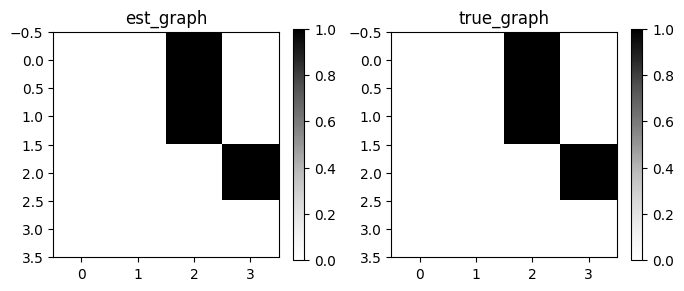

In [22]:
GraphDAG(
    est_dag=pc.causal_matrix, 
    true_dag=pc_dag)

plt.show()

In [23]:
MetricsDAG(
    B_est=pc.causal_matrix,
    B_true=pc_dag
).metrics

{'fdr': 0.0,
 'tpr': 1.0,
 'fpr': 0.0,
 'shd': 0,
 'nnz': 3,
 'precision': 1.0,
 'recall': 1.0,
 'F1': 1.0,
 'gscore': 1.0}

- iteratively 하게 하다보면 순서에 sensitive할 수 있는데 이를 보완한게 pc-stable 알고리즘


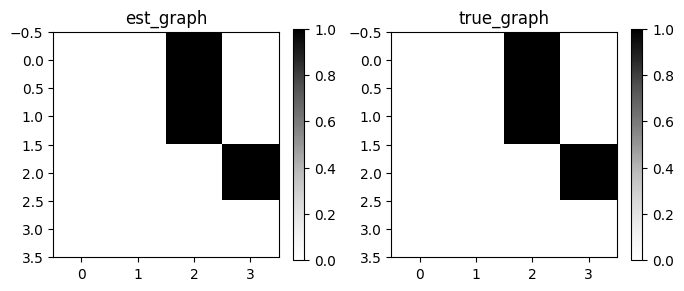

In [24]:
# PC-stable
pc_stable = PC(variant='stable')

# Fit 
pc_stable.learn(pc_dataset)

# Visualize
GraphDAG(
    est_dag=pc_stable.causal_matrix, 
    true_dag=pc_dag)

plt.show()

- 속도를 보완한게 parallel 알고리즘

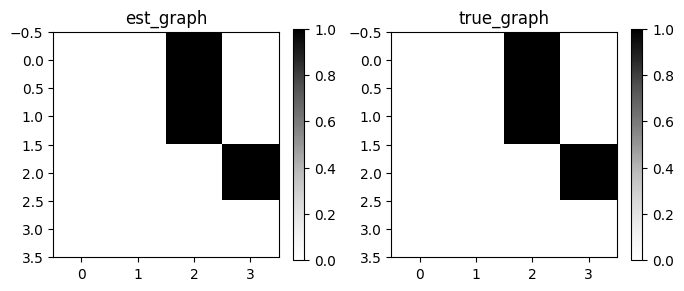

In [25]:
# PC-stable
pc_parallel = PC(variant='parallel')

# Fit 
pc_parallel.learn(pc_dataset)

# Visualize
GraphDAG(
    est_dag=pc_parallel.causal_matrix, 
    true_dag=pc_dag)

plt.show()

- category 데이터에도 사용할 수 있다.

In [26]:
# Generate the data
a = np.random.binomial(4, .5, N)
b = np.random.binomial(4, .5, N)
c = ((a + b + np.random.normal(0, 1, N)) > 2).astype(int)

# To matrix
pc_cat_dataset = np.vstack([a, b, c]).T

pc_cat_dataset.shape

(1000, 3)

In [27]:
# fit
pc_cat = PC(ci_test='chi2')
pc_cat.learn(pc_cat_dataset)
pc_cat.causal_matrix

Tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])

## Score-based causal discovery

## Functional causal discovery

## Gradient-based causal discovery

## Encoding expert knowledge

In [28]:
from castle.common.priori_knowledge import PrioriKnowledge

In [29]:
# Data simulation, simulate true causal dag and train_data.
true_dag = DAG.scale_free(n_nodes=10, n_edges=15, seed=SEED)


DATA_PARAMS = {
    'linearity': ['linear', 'nonlinear'], 
    'distribution': {
        'linear': ['gauss', 'exp'],
        'nonlinear': ['quadratic']
    }
}

datasets = {}

for linearity in DATA_PARAMS['linearity']:
    for distr in DATA_PARAMS['distribution'][linearity]:
        
        datasets[f'{linearity}_{distr}'] = IIDSimulation(
            W=true_dag, 
            n=2000, 
            method=linearity, 
            sem_type=distr)

2023-07-12 22:22:43,454 - /Users/kakao/.pyenv/versions/3.9.15/envs/causality-study/lib/python3.9/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2023-07-12 22:22:43,464 - /Users/kakao/.pyenv/versions/3.9.15/envs/causality-study/lib/python3.9/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2023-07-12 22:22:43,522 - /Users/kakao/.pyenv/versions/3.9.15/envs/causality-study/lib/python3.9/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


In [33]:
datasets

{'linear_gauss': <castle.datasets.simulator.IIDSimulation at 0x29e1d5100>,
 'linear_exp': <castle.datasets.simulator.IIDSimulation at 0x29e189c10>,
 'nonlinear_quadratic': <castle.datasets.simulator.IIDSimulation at 0x29e002790>}

In [30]:
priori_knowledge = PrioriKnowledge(n_nodes=10)

In [31]:
priori_knowledge.add_required_edges([(7, 3)])
priori_knowledge.add_forbidden_edges([(0, 9), (8, 6)])

In [32]:
pc_priori = PC(priori_knowledge=priori_knowledge)
pc_priori.learn(datasets['linear_gauss'].X)

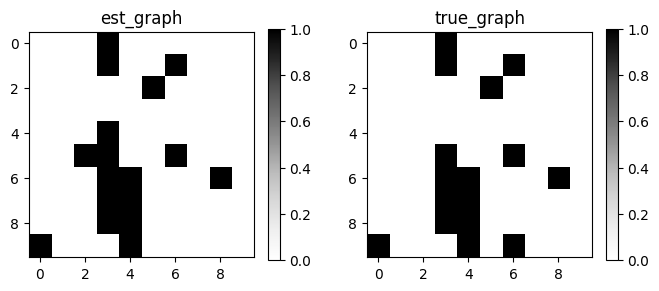

In [34]:
plt.style.use('default')

GraphDAG(
    est_dag=pc_priori.causal_matrix, 
    true_dag=true_dag)

plt.show()

In [35]:
mt = MetricsDAG(pc_priori.causal_matrix, true_dag)
print(f'FDR: {mt.metrics["fdr"]}')
print(f'Recall: {mt.metrics["recall"]}')
print(f'Precision: {mt.metrics["precision"]}')
print(f'F1 score: {mt.metrics["F1"]}')
print(f'SHD score: {mt.metrics["shd"]}')

FDR: 0.0625
Recall: 0.9375
Precision: 0.8824
F1 score: 0.9091
SHD score: 2
